In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Diabetes-Classification.csv')
data.head()
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         128 non-null    int64  
 1   Gender                      128 non-null    object 
 2   BMI                         125 non-null    float64
 3   Blood Pressure              128 non-null    object 
 4   FBS                         128 non-null    int64  
 5   HbA1c                       128 non-null    float64
 6   Family History of Diabetes  126 non-null    object 
 7   Smoking                     126 non-null    object 
 8   Diet                        126 non-null    object 
 9   Exercise                    127 non-null    object 
 10  Diagnosis                   128 non-null    object 
dtypes: float64(2), int64(2), object(7)
memory usage: 11.1+ KB


In [3]:
data = data.dropna()
data.isnull().sum()

Age                           0
Gender                        0
BMI                           0
Blood Pressure                0
FBS                           0
HbA1c                         0
Family History of Diabetes    0
Smoking                       0
Diet                          0
Exercise                      0
Diagnosis                     0
dtype: int64

In [4]:
data.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,45,Male,25.0,Normal,100,5.7,No,No,Healthy,Regular,No
1,55,Female,30.0,High,120,6.4,Yes,Yes,Poor,No,Yes
2,65,Male,35.0,High,140,7.1,Yes,Yes,Poor,No,Yes
3,75,Female,40.0,High,160,7.8,Yes,Yes,Poor,No,Yes
5,50,Female,25.0,Normal,100,5.7,No,No,Healthy,Regular,No


In [5]:
#Label Encoding
from sklearn.preprocessing import LabelEncoder

cat_col = ["Gender", "Blood Pressure", "Family History of Diabetes", "Smoking", "Diet", "Exercise", "Diagnosis"]
le = LabelEncoder()

for col in cat_col:
    data[col] = le.fit_transform(data[col])
    
data.head()

,Age,Gender,BMI,Blood Pressure,FBS,HbA1c,Family History of Diabetes,Smoking,Diet,Exercise,Diagnosis
0,45,1,25.0,2,100,5.7,0,0,0,1,0
1,55,0,30.0,0,120,6.4,1,1,1,0,1
2,65,1,35.0,0,140,7.1,1,1,1,0,1
3,75,0,40.0,0,160,7.8,1,1,1,0,1
5,50,0,25.0,2,100,5.7,0,0,0,1,0


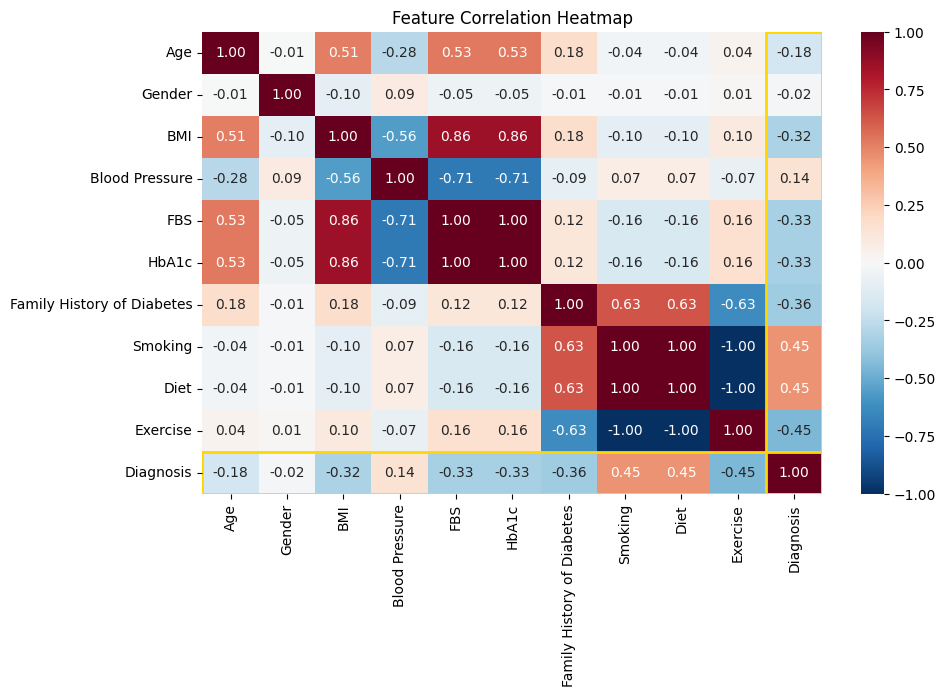

In [6]:
#EDA
import seaborn as sns
plt.figure(figsize=(10, 6))

#binary encode target variable first
corr = data.corr()
sns.heatmap(corr, annot=True, cmap='RdBu_r', fmt='.2f')

#formatting to highlight target variable
import matplotlib.patches as patches

ax = plt.gca()
n = corr.columns.get_loc("Diagnosis")  # get index of Diagnosis column
i = corr.index.get_loc("Diagnosis")
border1 = patches.Rectangle((n, 0), 1, corr.shape[0], linewidth = 2, edgecolor = 'gold', facecolor = 'none')
border2 = patches.Rectangle((0, i), corr.shape[0], 1, linewidth = 2, edgecolor = 'gold', facecolor = 'none')
ax.add_patch(border1)
ax.add_patch(border2)

plt.title('Feature Correlation Heatmap')
plt.show()

Comparing this to the heatmap for the one hot encoded dataset, we see that the figures for correlation are still the same but the data is not accurate. Important information has been lost. For example, it shows that the correlation between age and a diabetes diagnosis is negative, but that doesn't mean anything.

In [7]:
#Feature Selection; Removing irrelevant features, features that do not contribute to the target variable
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func = f_classif, k = 5)
x = data.drop(["Diagnosis"], axis = 1)
y = data["Diagnosis"]

#impute missing values for BMI
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
x_imputed = imputer.fit_transform(x)

x_selected = selector.fit_transform(x_imputed, y)
selected_features = x.columns[selector.get_support()]
print(selected_features)


Index(['FBS', 'Family History of Diabetes', 'Smoking', 'Diet', 'Exercise'], dtype='object')


In [8]:
x1 = data[selected_features] #dataframe with only selected features

#now train-test split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)
knn = KNeighborsClassifier(n_neighbors = 5)

#all features
knn.fit(x_train, y_train)
y_pred_knn = knn.predict(x_test)

In [9]:
#selected features
x1_train, x1_test, y1_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)
knn_selected = KNeighborsClassifier(n_neighbors = 5)
knn_selected.fit(x1_train, y_train)
y_pred_knn1 = knn_selected.predict(x1_test)

In [10]:
#Now compare results from an SVM model
from sklearn.svm import SVC

svm = SVC(kernel='rbf', C = 1, probability = True, random_state = 10)
svm_selected = SVC(kernel='rbf', C = 1, probability = True, random_state = 10)

#training models
#all features
svm.fit(x_train,y_train)
y_pred_svm = svm.predict(x_test)


#selcted features
svm_selected.fit(x1_train,y_train)
y_pred_svm1 = svm_selected.predict(x1_test)

In [11]:
# Classification reports for models using label encoded data

from sklearn.metrics import classification_report

print(f"KNN_Selected Performance:\n", classification_report(y_test, y_pred_knn1))
print("SVM_Selected Performance:\n", classification_report(y_test, y_pred_svm1))

KNN_Selected Performance:
               precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.17      0.33      0.22         6

    accuracy                           0.61        36
   macro avg       0.50      0.50      0.48        36
weighted avg       0.72      0.61      0.65        36

SVM_Selected Performance:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        30
           1       0.00      0.00      0.00         6

    accuracy                           0.83        36
   macro avg       0.42      0.50      0.45        36
weighted avg       0.69      0.83      0.76        36



C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_clas

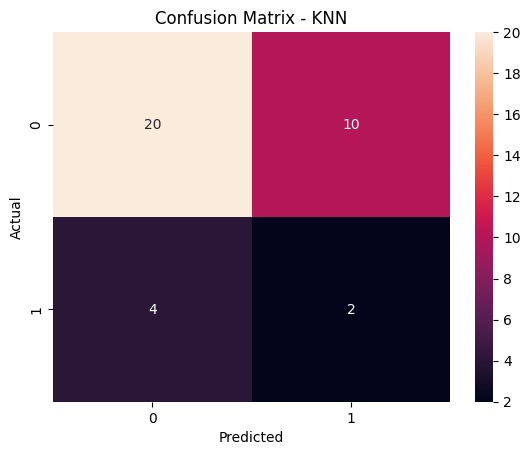

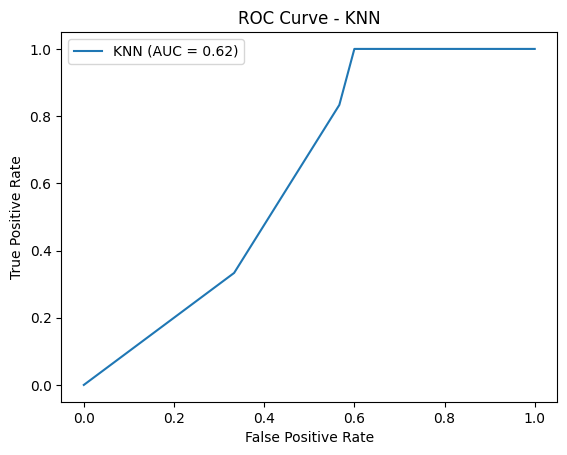

In [12]:
# Confusion Matrix for KNN
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

cm = confusion_matrix(y_test, y_pred_knn1)
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.show()

# ROC curve for KNN Model
y_prob = knn_selected.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label = f'KNN (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend()
plt.show()


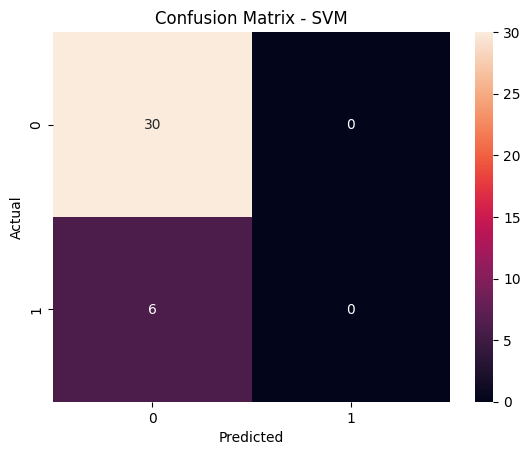

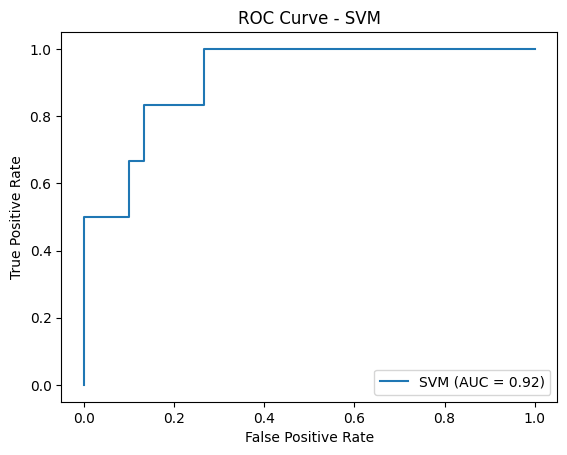

In [13]:
# Confusion Matrix for SVM
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

cm = confusion_matrix(y_test, y_pred_svm1)
sns.heatmap(cm, annot = True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

# ROC curve for SVM Model
y_probs = svm_selected.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label = f'SVM (AUC = {roc_auc_score(y_test, y_probs):.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.show()

These are exactly the same results generated for the one hot encoded data.

In conclusion, the numerical side of the work is not affected at all, but when it comes to interpreting the categorical data, the necessary information has been lost through label encoding.